# Introduction: 
This document contains executable code to accompany the writeup for candidate 1037074. Headers in this document correspond to headers in the writeup. All segments are executable, but some (e.g. the support vector machine training and the data science challenge) will take a particularly long time. In those cases, notes have been added. The environment in which you execute this will need to have TensorFlow and Keras installed. The data science challenge is included in a separate Python notebook to avoid overwhelming the kernel. 

# Question 1: Principal Component Analysis

## Data preprocessing: 
First, I import necessary packages. I then load in the MNIST dataset from Keras, which consists of pixel data for images of 60,000 hand-drawn digits. It is already split into train and test sets in Keras. Each pixel is an RGB value in the range [0, 255], so I divide each pixel by 255 to ensure that we have values between 0 and 1. For later use in the neural network, I create a version of the training and testing labels (y_train and y_test) with one-hot encoding (that is, the categorical number labels are transformed into a set of binary variables indicating whether is or isn't 1, 2, 3, et cetera). 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
mnist = tf.keras.datasets.mnist

(x_train_original, y_train_original),(x_test_original, y_test_original) = mnist.load_data()

#divide by 255 to normalize for later use: 
(x_train, y_train) = (x_train_original/255, y_train_original)
(x_test, y_test) = (x_test_original/255, y_test_original)

#make one hot encoder for later use
y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)

## PCA: 
In this code block, I flatten the data from a three-dimensional array (of dimension 60,000 x 28 x 28) into a two-dimensional one (of dimension 60,000 x 784) for use in PCA and then fit the PCA to the reshaped training data. I then standardize the data to have a mean of zero and a variance of one. This is standard practice for PCA to avoid misleading principal components that occur because one variable has a larger variance than others (which often occurs because variables are on different measurement scales, although this isn't the case here) (Murphy 2012: 389). Next,  I run a PCA with the maximum number of components (i.e. 784, the total number of pixels in each image) and select a more optimal number of components using the next set of plots. 

In [3]:
from sklearn.preprocessing import StandardScaler
#reshape data to two dimensions for PCA
x_train_reshaped = np.reshape(x_train_original, (x_train_original.shape[0], x_train_original.shape[1] * x_train_original.shape[2])).astype("float64")
x_test_reshaped = np.reshape(x_test_original, (x_test_original.shape[0], x_test_original.shape[1] * x_test_original.shape[2])).astype("float64")

#standardize (also standardize test data for later use in svm)
scaler = StandardScaler()
x_train_reshaped = scaler.fit_transform(x_train_reshaped, y_train_original)
x_test_reshaped = scaler.fit_transform(x_test_reshaped, y_test_original)

#fit PCA and transform
my_pca = PCA().fit(x_train_reshaped)
transformed = my_pca.transform(x_train_reshaped)
transformed_test_x = my_pca.transform(x_test_reshaped)

## Plots: scree plot and cumulative variance explained

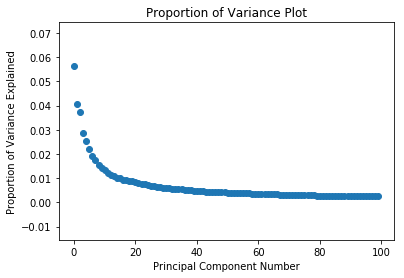

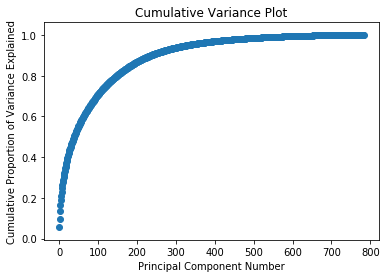

In [4]:
#plot 1: variance explained by first 100 principal components
plt.scatter(range(len(my_pca.components_[:100])), my_pca.explained_variance_ratio_[:100])
plt.title('Proportion of Variance Plot')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance Explained')
plt.savefig('variance_plot.png')
plt.show()

plt.scatter(range(len(my_pca.components_)), np.cumsum(my_pca.explained_variance_ratio_))
plt.title('Cumulative Variance Plot')
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.savefig('cum_variance_plot.png')
plt.show()

## Plot: PC1 vs. PC2

In the plot below, I show the original data points plotted on the new orthogonal axes defined by the first two principal components. Given the nature of the dataset—as a set of pixels—the principal components are difficult to interpret. However, there is clear clustering in Figure 3 for most of the labels. For instance, images of the digit $9$ have lower loadings on the first principal component and higher ones on the second, whereas the opposite is true for the digit $0$. 

,PCA1,PCA2,PCA3,label
0,-0.922159,-4.814790,0.067560,5
1,8.708977,-7.754403,-3.447910,0
2,2.328389,9.431338,-6.184114,4
3,-6.582173,-3.746318,3.690851,1
4,-5.183251,3.133297,-6.277947,9


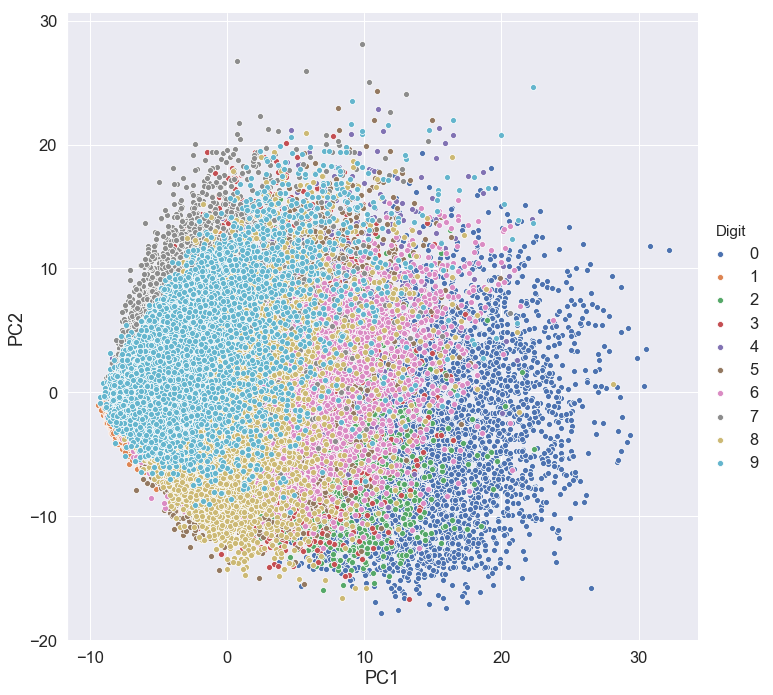

In [5]:
import seaborn as sns

sns.set(font_scale=1.5)

#create a new dataframe with loadings on each principal component
pca_df = pd.concat((pd.DataFrame(transformed[::, :3]), pd.Series(y_train)), axis=1)
pca_df.columns = ['PCA1', 'PCA2', 'PCA3', 'label']
display(pca_df.head())

#use loadings for seaborn plot
pc_plot = sns.pairplot(x_vars=['PCA1'], y_vars=['PCA2'], data=pca_df, hue='label', height=10)
pc_plot._legend.set_title('Digit')
pc_plot.set(xlabel='PC1', ylabel='PC2')
pc_plot.savefig('pc_plot.png')

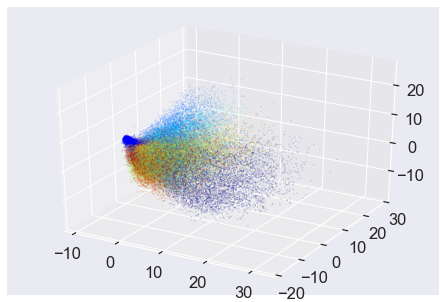

In [6]:
#example 3d plot, not used in writeup
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(transformed[:,0], transformed[:,1], transformed[:,2], cmap=plt.get_cmap('jet', 10), c = list(y_train), s = 0.01)
plt.show()

# Support vector machines:

## Preprocessing: 

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#create subset for test
mask = np.random.randint(x_train_reshaped.shape[0], size=1000)
x_train_subset = x_train_reshaped[mask, :]
y_train_subset = y_train_original[mask]

#check shapes
print(x_train_subset.shape)
print(y_train_subset.shape)

(1000, 784)
(1000,)


## SVMs with various kernels: 

### Linear kernel: 
Below, I use five-fold cross-validation to tune the cost hyperparameter for a linear kernel SVC. Five fold cross-validation is a specific case of k-fold cross-validation, in which the training data are split into k = 5 "folds," and the model is tested once on each fold, with the other k - 1 = 4 folds being used as training data. This process is executed once for each value of the cost parameter to determine which of the given cost values performs the best. 

In [8]:
#cross validation: 
params = {'C': [0.0001, 0.001, 0.01,0.1,1,10,100,1000,10000,100000]}
lin_svc = SVC(kernel='linear')

#grid search, parallelized, set for four cores
gridsearch = GridSearchCV(lin_svc, params, cv=5, n_jobs=4).fit(x_train_subset, y_train_subset)
print("Best estimator:", gridsearch.best_estimator_)
print("Best parameters:", gridsearch.best_params_)

/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator: SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Best parameters: {'C': 0.01}


In [9]:
#evaluation: 
best = gridsearch.best_estimator_.fit(x_train_subset, y_train_subset)
print(best.score(x_test_reshaped, y_test_original))

0.8965


### Quadratic kernel: 

In [10]:
#cross validation: 
poly_params = {'C': [0.0001, 0.001, 0.01,0.1,1,10,100,1000,10000,
                     100000]}

poly_svc = SVC(kernel='poly', degree=2)
#same as above
poly_gridsearch = GridSearchCV(poly_svc, poly_params, cv=5, n_jobs=4).fit(x_train_subset, y_train_subset)
print("Best estimator:", poly_gridsearch.best_estimator_)
print("Best parameters:", poly_gridsearch.best_params_)

/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best estimator: SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Best parameters: {'C': 10}


In [11]:
#evaluation: 
best_poly = poly_gridsearch.best_estimator_.fit(x_train_subset, y_train_subset)
print(best_poly.score(x_test_reshaped, y_test_original))

/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8936


### Exponential kernel: 

In [12]:
rbf_params = {'C': [0.0001, 0.001, 0.01,0.1,1,10,100,1000,10000,
                     100000], 'gamma': [10**-4, 10**-3, 10**-2,
                                       10**-1, 1]}

rbf_svc = SVC(kernel='rbf')
rbf_gridsearch = GridSearchCV(rbf_svc, rbf_params, cv=5, n_jobs=4).fit(x_train_subset, y_train_subset)
print("Best estimator:", rbf_gridsearch.best_estimator_)
print("Best parameters:", rbf_gridsearch.best_params_)

/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator: SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best parameters: {'C': 1000, 'gamma': 0.0001}


In [13]:
best_rbf = rbf_gridsearch.best_estimator_.fit(x_train_subset, y_train_subset)
print(best_rbf.score(x_test_reshaped, y_test_original))

0.8944


# (3) Neural Networks: 

## Coding: 

### Data preprocessing: 

In [14]:
#one-hot encoding for neural network
y_train = np.asarray(pd.get_dummies(y_train))
y_test = np.asarray(pd.get_dummies(y_test))

x_train_reshaped, y_train, x_test_reshaped, y_test = x_train_reshaped.T, y_train.T, x_test_reshaped.T, y_test.T
print(x_train_reshaped.shape, y_train.shape)
print(x_test_reshaped.shape, y_test.shape)

(784, 60000) (10, 60000)
(784, 10000) (10, 10000)


In [15]:
class NeuralNet(): 
    def __init__(self, hidden_size, X, output_size, y):
        self.m = X.shape[1]
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        #shuffle data for sgd
        np.random.seed(129)
        shuffle = np.random.permutation(self.m)
        self.X = X[:,shuffle]
        self.y = y[:,shuffle]

        #input layer to hidden layer: zero biases, random weights
        self.biases1 = np.zeros((hidden_size, 1))
        self.weights1 = np.random.randn(self.X.shape[0], hidden_size)
        
        #hidden layer to output layer
        self.biases2 = np.zeros((output_size, 1))
        self.weights2 = np.random.randn(hidden_size, output_size)
        
    #define sigmoid function
    def sigmoid(self, z):
        return (1 / (1 + np.exp(-z)))
    
    #see derivation in (a)
    def sigmoid_deriv(self, z): 
        return (self.sigmoid(z) * (1 - self.sigmoid(z)))
    
    def softmax(self, z):
        return np.exp(z)/np.sum(np.exp(z), axis=0)
    
    #compare true labels to predicted labels
    def multi_class_loss(self, y_true, y_hat): 
        loss_sum = np.sum(np.multiply(y_true, np.log(y_hat)))
        loss = (-1/self.m) * loss_sum
        return loss
    
    def feedforward(self, X_sgd): 
        #w^Tx + b
        z1 = np.matmul(self.weights1.T,X_sgd) + self.biases1
        
        #pass z1 as activation to next layer
        a1 = self.sigmoid(z1) 
        z2 = np.matmul(self.weights2.T, a1) + self.biases2
        
        #softmax instead of sigmoid for the final layer: 
        a2 = self.softmax(z2)
        
        #return as dictionary for easier access later
        a_and_z = {'a1': a1, 'a2': a2, 'z1': z1, 'z2': z2}
        return a_and_z
    
    def backpropagation(self, X_sgd, y_sgd, lr = 0.8): 
        #y_sgd = the shape of a single example passed through in sgd
        m = y_sgd.shape[0]
        
        W1 = self.weights1
        W2 = self.weights2
        b1 = self.biases1
        b2 = self.biases2
        
        #calculate loss
        a_z = self.feedforward(X_sgd)
        y_hat_sgd = a_z['a2']
        loss = self.multi_class_loss(y_sgd, y_hat_sgd)
        
        #inspired by: https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/
        dZ2 = y_hat_sgd-y_sgd
        dW2 = (1./m) * np.matmul(dZ2, a_z['a1'].T)
        db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(W2, dZ2)
        dZ1 = dA1 * self.sigmoid_deriv(a_z['z1'])
        dW1 = (1./m) * np.matmul(dZ1, X_sgd.T)
        db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

        #update weights and biases, scaled by learning rate
        #transpose to get 
        self.weights2 = W2 - lr * dW2.T
        self.biases2 = b2 - lr * db2
        
        self.weights1 = W1 - lr * dW1.T
        self.biases1 = b1 - lr * db1
        return loss
        
    def fit(self, epochs = 10):
        for i in range(epochs): 
            costs = np.ndarray((self.m,))
            for j in range(self.m):
                in_x = np.asarray([self.X[:,j]]).T
                in_y = np.asarray([self.y[:,j]]).T
                cost = self.backpropagation(in_x, in_y)
                costs[j] = cost

            print("Epoch", i, "cost:", costs.mean())
                
    def predict(self,X_test, y_test):
        a_z = self.feedforward(X_test)
        Z1 = np.matmul(self.weights1.T, X_test) + self.biases1
        A1 = self.sigmoid(Z1)
        Z2 = np.matmul(self.weights2.T, A1) + self.biases2
        A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

        predictions = np.argmax(A2, axis=0)
        labels = np.argmax(y_test, axis=0)
        return predictions, labels

### Neural network training: 

In [16]:
print(y_train.shape)
my_nn = NeuralNet(100, x_train_reshaped, 10, y_train) 

my_nn.fit(10)

(10, 60000)
Epoch 0 cost: 1.128306784713711e-05
Epoch 1 cost: 7.159969085884581e-06
Epoch 2 cost: 5.950638552459152e-06
Epoch 3 cost: 5.233458769440588e-06
Epoch 4 cost: 4.751161430404671e-06
Epoch 5 cost: 4.361773443590474e-06
Epoch 6 cost: 4.054865303525678e-06
Epoch 7 cost: 3.7242319194602562e-06
Epoch 8 cost: 3.5412199758343535e-06
Epoch 9 cost: 3.330596370685913e-06


### Neural network testing: 

In [17]:
predictions, labels = my_nn.predict(x_test_reshaped, y_test)

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[ 949    0    7    0    1   12   10    1    5    4]
 [   0 1102    0    2    0    1    2    3    4    2]
 [  11   11  988   44    9    9   14   19   23    7]
 [   1    2    2  901    0   23    1    5   15   13]
 [   0    0    2    0  882    6    5    3    7   13]
 [   2    1    2   16    0  787    4    0    7    3]
 [   6    4    6    4   21   12  919    0    9    1]
 [   6    9   15   17   21   10    2  980   17   45]
 [   4    5   10   20    2   24    1    2  876    2]
 [   1    1    0    6   46    8    0   15   11  919]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       989
           1       0.97      0.99      0.98      1116
           2       0.96      0.87      0.91      1135
           3       0.89      0.94      0.91       963
           4       0.90      0.96      0.93       918
           5       0.88      0.96      0.92       822
           6       0.96      0.94      0.95       982
           7       0.95      0.87   

## (c) Practical:

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [ ]:
model = Sequential()
#flatten the input so that it's 2D
model.add(Flatten(input_shape=(28, 28)))
#add a layer with 1200 neurons
model.add(Dense(1200, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(1200, activation=tf.nn.relu))
#added because we have categorical output with 10 categories
model.add(Dropout(0.5))
model.add(Dense(10, activation=tf.nn.softmax))
#model.add(Dropout(0.5))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train_onehot, validation_split = 0.2, epochs=20, batch_size=128)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20


In [5]:
metrics = model.model.evaluate(x_test, y_test_onehot, verbose=2)
print("Test loss:", metrics[0])
print("Test accuracy:", metrics[1])

/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Test loss: 0.06994141991111974
Test accuracy: 0.9826


In [18]:
model2 = Sequential()
#flatten the input so that it's 2D
model2.add(Flatten(input_shape=(28, 28)))
#add a layer with 1200 neurons
model2.add(Dense(1200, activation=tf.nn.relu))
model2.add(Dropout(0.5))
model2.add(Dense(1200, activation=tf.nn.relu))
model2.add(Dropout(0.5))
#added because we have categorical output with 10 categories
model2.add(Dense(10, activation=tf.nn.softmax))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(x_train, y_train_onehot, validation_split = 0.2, epochs=20, batch_size=128)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.3000 - acc: 0.9077 - val_loss: 0.1323 - val_acc: 0.9597
Epoch 2/20
48000/48000 [==============================] - 66s 1ms/step - loss: 0.1427 - acc: 0.9561 - val_loss: 0.1016 - val_acc: 0.9684
Epoch 3/20
48000/48000 [==============================] - 82s 2ms/step - loss: 0.1117 - acc: 0.9660 - val_loss: 0.0888 - val_acc: 0.9733
Epoch 4/20
48000/48000 [==============================] - 76s 2ms/step - loss: 0.0951 - acc: 0.9702 - val_loss: 0.0870 - val_acc: 0.9734
Epoch 5/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.0810 - acc: 0.9736 - val_loss: 0.0828 - val_acc: 0.9747
Epoch 6/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.0716 - acc: 0.9775 - val_loss: 0.0726 - val_acc: 0.9780
Epoch 7/20
48000/48000 [==============================] - 64s 1ms/step - loss: 0.0687 - acc: 0.9770 - val_loss: 0.0855 - val_acc

In [5]:
metrics = model2.model.evaluate(x_test, y_test_onehot, verbose=2)
print("Test loss:", metrics[0])
print("Test accuracy:", metrics[1])

NameError: name 'model2' is not defined